In [55]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

seed=42

In [56]:
from transformers import BertTokenizerFast
from transformers import TFBertModel

In [57]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


In [58]:
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 640x480 with 0 Axes>

In [59]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Positive', 'Neutral']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [60]:
df = pd.read_csv('/kaggle/input/smsa-tokenized-emoji-dataset/amerix_smsa_adv_emoji_ecoded_data.csv', index_col=0)

In [61]:
df.head()

,tweet_created_at,text_clean_deeper,Sentiment
154462,2022-06-08 11:44:34+00:00,wishing the team the best today the team has i...,1
98658,2022-11-07 22:49:01+00:00,all humans are bettertogether voteblue resist ...,2
73057,2022-10-29 05:34:53+00:00,lemme retweet share screenshot and tag this fe...,1
124877,2022-08-21 23:58:59+00:00,keep pushing multiple aeds are so important fo...,1
99068,2022-11-06 02:45:54+00:00,this is my only points slip this was 80k this ...,1


In [62]:
df.shape

(233687, 3)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233687 entries, 154462 to 17279
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tweet_created_at   233687 non-null  object
 1   text_clean_deeper  233687 non-null  object
 2   Sentiment          233687 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 7.1+ MB


In [64]:
ros = RandomOverSampler()

train_x, train_y = ros.fit_resample(np.array(df['text_clean_deeper']).reshape(-1, 1), 
                                    np.array(df['Sentiment']).reshape(-1, 1))

ros_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), 
                      columns = ['text_clean_deeper', 'Sentiment'])

In [65]:
ros_df['Sentiment'].value_counts()

1    129190
2    129190
0    129190
Name: Sentiment, dtype: int64

In [66]:
X = ros_df['text_clean_deeper'].values
y = ros_df['Sentiment'].values

In [67]:
x_, x_test, y_, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [68]:
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size=0.2, stratify=y_, random_state=42)

In [69]:
y_train_c = y_train.copy()
y_valid_c = y_val.copy()
y_test_c = y_test.copy()

In [70]:
encoder = preprocessing.OneHotEncoder()

y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = encoder.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [71]:
print(f"Training Data: {x_train.shape[0]}\nValidation Data: {x_val.shape[0]}\nTesting Data: {x_test.shape[0]}")

Training Data: 217039
Validation Data: 54260
Testing Data: 116271


In [72]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [73]:
MAX_LEN = 200

def tokenize(data, max_len=MAX_LEN) :
    
    input_ids = []
    attention_masks = []
    
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [74]:
train_input_ids, train_attention_masks = tokenize(x_train, MAX_LEN)

val_input_ids, val_attention_masks = tokenize(x_val, MAX_LEN)

test_input_ids, test_attention_masks = tokenize(x_test, MAX_LEN)

In [75]:
bert_classifier = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [76]:
def create_model(bert_model, max_len=MAX_LEN):
    
    #parameters
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_classifier([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [77]:
brt_model = create_model(bert_classifier, MAX_LEN)
brt_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 200,                                         

In [78]:
bert_train_tune = brt_model.fit([train_input_ids,train_attention_masks], 
                         y_train, 
                         validation_data = ([val_input_ids,val_attention_masks], y_val), 
                         epochs=4, batch_size=32)

Epoch 1/4
6783/6783 [==============================] - 5548s 811ms/step - loss: 0.2810 - categorical_accuracy: 0.9013 - val_loss: 0.1717 - val_categorical_accuracy: 0.9454
Epoch 2/4
6783/6783 [==============================] - 5493s 810ms/step - loss: 0.1358 - categorical_accuracy: 0.9565 - val_loss: 0.1242 - val_categorical_accuracy: 0.9594
Epoch 3/4
6783/6783 [==============================] - 5491s 810ms/step - loss: 0.0912 - categorical_accuracy: 0.9705 - val_loss: 0.1211 - val_categorical_accuracy: 0.9623
Epoch 4/4
6783/6783 [==============================] - 5484s 809ms/step - loss: 0.0620 - categorical_accuracy: 0.9797 - val_loss: 0.1199 - val_categorical_accuracy: 0.9669


In [79]:
bert_prediction = brt_model.predict([test_input_ids,test_attention_masks])

3634/3634 [==============================] - 923s 253ms/step


In [80]:
bert_y_predictions =  np.zeros_like(bert_prediction)
bert_y_predictions[np.arange(len(bert_y_predictions)), bert_prediction.argmax(1)] = 1

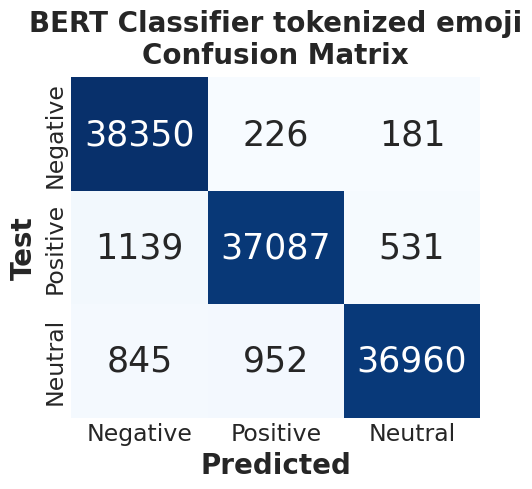

In [81]:
conf_matrix(y_test.argmax(1), bert_y_predictions.argmax(1),'BERT Classifier tokenized emoji\nConfusion Matrix')

In [82]:

print('\tBERT Classification Report\n\n',classification_report(y_test,bert_y_predictions, 
                                                                    target_names=['Negative', 'Positive', 'Neutral']))

	BERT Classification Report

               precision    recall  f1-score   support

    Negative       0.95      0.99      0.97     38757
    Positive       0.97      0.96      0.96     38757
     Neutral       0.98      0.95      0.97     38757

   micro avg       0.97      0.97      0.97    116271
   macro avg       0.97      0.97      0.97    116271
weighted avg       0.97      0.97      0.97    116271
 samples avg       0.97      0.97      0.97    116271

